# Basic setup for fetching data from the facebook api

### Remember to add an active access token below and adjust the parameters and fields if necessary

In [ ]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

# Generates a dataset (in the data directory)
# requestor = API_request()
# requestor.generate_dataset(500, "Joe Biden", "EAAD3So8oorMBAIgWyz9birkjFZCRkyKZADF6qfnmkZC41UPKMzeoSWPXLXxNTBiFP9td55s5TZCOKfAoheAmRih0U7TjaCCDsDQwZAZCBPH2pGQtx6y9e9Keouk8JosvkuLPxs451MY3QGrzZAgiZAVKFJZBxZCIFxHIKHVJmn8uwnGsJaMKh1mQIknChEeYf16tYyZCZBehAo4VToZCuqW0P5KL2")


In [ ]:
# Returns text file as dataframe with transformations
preprocess = Preprocessor()
# data = preprocess.file_to_df("..\\data\\generated_dataset.txt")

In [ ]:
data.head(10)

In [ ]:
'''
Visualization attempts
https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
'''
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting spending over time and impressions over time 
fig, axes = plt.subplots(2,1,figsize=(8,4))
data.plot(x="ad_creation_time", y="impressions", ax=axes[0])
data.plot(x="ad_creation_time", y="spend", ax=axes[1])

In [ ]:
# Plot range of impressions
plt.fill_between(x=data["ad_creation_time"], y1=data["impressions_lo"], y2=data["impressions_hi"], alpha=1, color="green")
plt.plot(data["ad_creation_time"], data["impressions"])
plt.show()

In [ ]:
'''
Amount spend by facebook page
'''
by_page = data.groupby("page_name").agg(
    # Aggregate no of ads
    no_ads = ('id', 'count'),
    # Aggregate sum of spend & total impressions generated
    spend_lo = ('spend_lo', 'sum'),
    spend_hi = ('spend_hi', 'sum'),
    impressions_lo = ('impressions_lo', 'sum'),
    impressions_hi = ('impressions_hi', 'sum'),
    # Average number of impressions & spend per ad
    avg_impressions = ('impressions', 'mean'),
    avg_spend = ('spend', 'mean')

).reset_index()

by_page

In [ ]:
# Display range of spend

# Maybe normalize it
plt.fill_between(x=by_page["page_name"], y1=by_page["spend_lo"], y2=by_page["spend_hi"], alpha=1, color="green")
plt.plot(by_page["page_name"], by_page["spend"])
plt.show()

In [ ]:
'''
Congress member filtering
'''
# Get page-ids:
# https://commentpicker.com/find-facebook-id.php


congress_members = pd.DataFrame(pd.read_csv("..\\src\\data_sets\\legislators-current.csv"))

In [ ]:
congress_members["facebook"]

In [ ]:
congress_members["facebook"].isnull().sum()

In [ ]:
# Scraper experiement
# https://github.com/kevinzg/facebook-scraper

from facebook_scraper import get_page_info

page = get_page_info(account="SenatorBobCasey")

page

In [ ]:
import time

members_fbNames_test = [] # list of tuples

for value in congress_members["facebook"].items():
    if not pd.isnull(value[1]):
        page = get_page_info(account=value[1])
        print(page)
        if "name" and "identifier" in page:
            members_fbNames_test.append((value[1], page["name"], page["identifier"]))
            print(page["name"] + " id:" + str(page["identifier"]))
    time.sleep(0.5)

In [ ]:
members_names = pd.DataFrame(members_fbNames_test, columns=["facebook", "page_name", "identifier"])
# Save data as csv
members_names.to_csv("..\\src\\data_sets\\legislators_page_ids.csv", index=False, header=True)

In [ ]:
members_names_cp = members_names.copy()

In [ ]:
congress_members_fb = congress_members[["first_name", "last_name", "full_name", "type", "state", "district", "party", "facebook"]]

merged = congress_members_fb.merge(right=members_names, on="facebook", how="left")

In [ ]:
merged["identifier"] = merged["identifier"].fillna(0).astype(np.int64)

In [ ]:
merged["identifier"] = merged["identifier"].astype(np.int64)

In [ ]:
merged.to_csv("..\\src\\data_sets\\legislators_fb_info.csv", index=False, header=True)

In [ ]:
congress = pd.read_csv("..\\src\\data_sets\\legislators_fb_info.csv")

In [ ]:
report = pd.read_csv("..\\data\\FacebookAdLibraryReport_2021-10-15_US_lifelong_advertisers.csv")

In [ ]:
len(report[report["Page Name"].str.contains("Kpoadjioasdjqwodjas", na=False)]) == 0

In [ ]:
def get_page_id(data: pd.DataFrame, name: str):
    match = data[data["Page Name"].str.contains(name, na=False)]
    if len(match) != 0:
        return match.iloc[0][0]
    else:
        return "no match"


In [ ]:
congress["page_id"] = congress.apply(lambda x: get_page_id(report,x["full_name"]),axis=1)

In [ ]:
import pandas as pd
congress = pd.read_csv("..\\src\\data_sets\\legislators_fb_info.csv")

In [ ]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

data = preprocess.file_to_df("..\\data\\dataset_by_pageId.txt")

data.shape

In [ ]:
congress = pd.read_csv("..\\src\\data_sets\\legislators_fb_info.csv")

congress

In [ ]:
# test
# trying to make continuous loop to fetch all data
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

requestor = API_request()

count = 0
while count < 20:
    query = []
    for i in range(10):
        if count < len(congress):
            query.append(congress.loc[count]["page_id"])
            count +=1
    # clean query / remove "no match"
    clean_query = []
    for i in range(len(query)):
        if query[i] != "no match":
            clean_query.append(query[i])
    print(clean_query)
    
    requestor.append_dataset_by_pageId(500, clean_query, "EAAD3So8oorMBAL9qzc2ZBrrDaNqfJkAbHy6KPqZCqNmhOAvAzEIauoJOqruWt4f9oIiw4YsgX7Qs5l4y291PQBery6ZBBDOnKvxV4lGx6ZCOZChxMdCOvz9GNGstwdgtGUakHzmNYbldZBjNZBFyMjb9ZACYVygAcFToyMkK5cfp4s9C4mvjIBD1OBkvuZBWAB4IRcZB4XXEZBiVWo2ZAJWIfNIJnocHmW5EZB9ZAIkT60Ddbwf0IlFmwUWpFNH4YGVx3uESAZD")
        

In [ ]:
pid_list = congress[congress["page_id"] != "no match"]["page_id"].tolist()
congress_pid_set = set(pid_list)

In [ ]:
politician = congress[congress["page_id"] == '99332606976']
politician.full_name.values[0].replace(" ", "_")

In [ ]:
'''
Put page ids in set, then fetch results and write to single file
'''
# fetch all ads by one page and concatenate them to final file
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor
import json

pid_list = congress[congress["page_id"] != "no match"]["page_id"].tolist()
congress_pid_set = set(pid_list) # make set of page ids

requestor = API_request() # api connection

counter = 0
while len(congress_pid_set) > 0:
    p_id = congress_pid_set.pop() # get next page_id
    politician = congress[congress["page_id"] == p_id]  # get corresponding entry in df
    politician_name = politician.full_name.values[0].replace(" ", "_") # name of politician
    try:
        print(f"Try politician {politician_name} and count: {counter}") 
        ads_data = requestor.dataset_by_pageId_asString(500, [p_id], "EAAD3So8oorMBABhmqkfCTbdsKVDNfxuIhTg7ZA2FM2ZC2fwopiVQht5gQBtwjzwYu78qUKMyvCf7k8YsWtGcjlATEe2vWtO6i0GIpigRaiM88kk6J78TvGsoSx90wRwH2zb3hMVSjHFn4clmzFh2WBQcvOPPxGaYqAG95rtzJndaVw2vQwPEHt2r7LCt13zIftmrcltXEvAi0BJ2paB2gZADuY1DdQExAOp1OOo9Mq1gJMRR0ldsUulZApzkkUsZD")
        final_str = json.dumps(ads_data) 
        jsonFile = open(f"..\\single_files\\{politician_name}_{p_id}.txt", "w") # filepath and name specified here!
        jsonFile.write(final_str)
        jsonFile.close()
        print(f"Successfully created file for {politician_name}. Length of set is now: {len(congress_pid_set)}")
    except:
        congress_pid_set.add(p_id) # add element back to set and try again
        print(f"Error occured for politician {politician_name} with page_id {p_id}")
        pass

In [ ]:
'''
Takes page_ids one by one, store results in python list and when done, writes it to file
'''
# fetch all ads by one page and concatenate them to final file
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor
import json

requestor = API_request()

count = 0
final_file = []


while count < len(congress):
    politician_name = congress.loc[count]["full_name"]
    page_id = congress.loc[count]["page_id"]
    print(f"Try politician {politician_name}")
    if page_id != "no match":
        print(f"Page ID exists!")
        final_file.extend(requestor.dataset_by_pageId_asString(500, [page_id], "EAAD3So8oorMBAL9qzc2ZBrrDaNqfJkAbHy6KPqZCqNmhOAvAzEIauoJOqruWt4f9oIiw4YsgX7Qs5l4y291PQBery6ZBBDOnKvxV4lGx6ZCOZChxMdCOvz9GNGstwdgtGUakHzmNYbldZBjNZBFyMjb9ZACYVygAcFToyMkK5cfp4s9C4mvjIBD1OBkvuZBWAB4IRcZB4XXEZBiVWo2ZAJWIfNIJnocHmW5EZB9ZAIkT60Ddbwf0IlFmwUWpFNH4YGVx3uESAZD"))
    count += 1

jsonFile = open("..\\data\\dataset_by_pageId_appended.txt", "w") # filepath and name specified here!
        
final_file_str = json.dumps(final_file)
jsonFile.write(final_file_str)
jsonFile.close()

In [ ]:

# # load existing file
# with open('..\\data\\dataset_by_pageId_appended.txt') as f:
# existing_file = json.load(f)
# existing_file.extend(final_response) # add string to file
import json

jsonFile = open("..\\data\\dataset_by_pageId_appended.txt", "w") # filepath and name specified here!
        
final_file_str = json.dumps(final_file)
jsonFile.write(final_file_str)
jsonFile.close()

In [53]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

data = preprocess.file_to_df("..\\data\\dataset_by_pageId.txt")


In [54]:
data[data["ad_creative_body"].str.contains("Climate", na=False)]

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
905,2018-10-16,Early vote is open in Ohio! Get to the polls a...,649.5,54999.5,"[{'percentage': '1', 'region': 'Ohio'}]","[{'percentage': '0.200541', 'age': '18-24', 'g...",6266829799,Sherrod Brown,Friends of Sherrod Brown,2177481629238196,600,699,50000,59999
906,2018-10-16,Early vote is open in Ohio! Get to the polls a...,549.5,47499.5,"[{'percentage': '1', 'region': 'Ohio'}]","[{'percentage': '0.200116', 'age': '18-24', 'g...",6266829799,Sherrod Brown,Friends of Sherrod Brown,1761456297313169,500,599,45000,49999
2000,2018-10-16,Early vote is open in Ohio! Get to the polls a...,649.5,54999.5,"[{'percentage': '1', 'region': 'Ohio'}]","[{'percentage': '0.200541', 'age': '18-24', 'g...",6266829799,Sherrod Brown,Friends of Sherrod Brown,2177481629238196,600,699,50000,59999
2001,2018-10-16,Early vote is open in Ohio! Get to the polls a...,549.5,47499.5,"[{'percentage': '1', 'region': 'Ohio'}]","[{'percentage': '0.200116', 'age': '18-24', 'g...",6266829799,Sherrod Brown,Friends of Sherrod Brown,1761456297313169,500,599,45000,49999


In [55]:
by_page = preprocess.group_by_pages(data)
by_page

,page_name,no_ads,spend_lo,spend_hi,impressions_lo,impressions_hi,avg_impressions,avg_spend
0,Claudia Tenney Wrong for NY,100,197000,241100,9286000,10825900,100559.500000,2190.500000
1,Congressman Troy A. Carter,106,13600,24894,1612000,1951894,16810.820755,181.575472
2,Congressman-Elect Troy A. Carter,142,200,14258,376000,525858,3175.556338,50.908451
3,Jake Ellzey,372,75600,119628,4108000,5085628,12357.026882,262.403226
4,Julia Letlow,58,16200,23542,1086000,1291942,20499.500000,342.603448
5,Maria Cantwell,204,496400,641796,29314000,32495806,151494.622549,2789.696078
6,Senator Troy A. Carter,288,41600,72512,4038000,4975712,15648.805556,198.111111
7,Sherrod Brown,920,951400,1236880,46412000,52969090,54011.461957,1189.282609


In [56]:
# all ads by top 10 politicians
top_10 = by_page[:10]
ads_top_10 = data[data.page_name.isin(top_10["page_name"])]
ads_top_10.head(10)

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
0,2021-10-11,It’s time to stand up and take action. Will yo...,149.5,27499.5,"[{'percentage': '1', 'region': 'Louisiana'}]","[{'percentage': '6.0E-5', 'age': '18-24', 'gen...",101501768597429,Julia Letlow,Julia Letlow for Congress,603707424313907,100,199,25000,29999
1,2021-10-04,The Biden Administration’s Tax Plan could give...,49.5,499.5,NaN,NaN,101501768597429,Julia Letlow,Julia Letlow for Congress,992617231281367,0,99,0,999
2,2021-09-30,Let’s take a stand to help elect more represen...,249.5,42499.5,"[{'percentage': '0.013031', 'region': 'Alabama...","[{'percentage': '7.5E-5', 'age': '13-17', 'gen...",101501768597429,Julia Letlow,Julia Letlow for Congress,191730886406119,200,299,40000,44999
3,2021-09-30,It’s time to stand up and take action. Will yo...,249.5,37499.5,"[{'percentage': '1', 'region': 'Louisiana'}]","[{'percentage': '0.00018', 'age': '25-34', 'ge...",101501768597429,Julia Letlow,Julia Letlow for Congress,906001430329012,200,299,35000,39999
4,2021-09-30,The Biden Administration’s Tax Plan could give...,149.5,27499.5,"[{'percentage': '1', 'region': 'Louisiana'}]","[{'percentage': '0.000316', 'age': '45-54', 'g...",101501768597429,Julia Letlow,Julia Letlow for Congress,586279359164799,100,199,25000,29999
5,2021-09-30,Many hard-working Americans and Louisianians d...,49.5,1499.5,"[{'percentage': '1', 'region': 'Louisiana'}]","[{'percentage': '0.001484', 'age': '45-54', 'g...",101501768597429,Julia Letlow,Julia Letlow for Congress,260946802572152,0,99,1000,1999
6,2021-09-29,Biden has created a border crisis of epic prop...,849.5,27499.5,"[{'percentage': '1', 'region': 'Texas'}]","[{'percentage': '0.000517', 'age': '35-44', 'g...",512954815727434,Jake Ellzey,JAKE ELLZEY FOR CONGRESS,898052660842506,800,899,25000,29999
7,2021-09-29,We must stop the left-wing's radical indoctrin...,249.5,7499.5,"[{'percentage': '1', 'region': 'Texas'}]","[{'percentage': '0.001311', 'age': '45-54', 'g...",512954815727434,Jake Ellzey,JAKE ELLZEY FOR CONGRESS,166061815713183,200,299,7000,7999
8,2021-09-29,"In Texas, we must remain pro-life, and we can'...",249.5,8499.5,"[{'percentage': '1', 'region': 'Texas'}]","[{'percentage': '0.001008', 'age': '25-34', 'g...",512954815727434,Jake Ellzey,JAKE ELLZEY FOR CONGRESS,139306675017925,200,299,8000,8999
9,2021-09-29,We must defend the integrity of our elections ...,149.5,3499.5,"[{'percentage': '1', 'region': 'Texas'}]","[{'percentage': '0.000619', 'age': '25-34', 'g...",512954815727434,Jake Ellzey,JAKE ELLZEY FOR CONGRESS,979059726011253,100,199,3000,3999


Text(0.5, 1.0, 'Spend per ad')

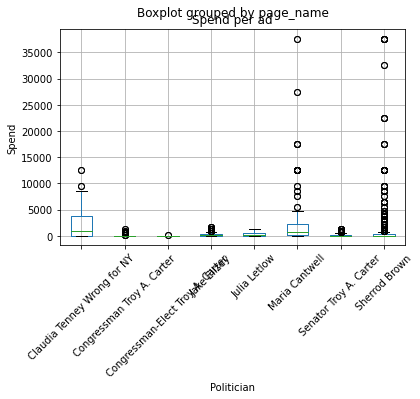

In [57]:
# Boxplot showing outliers of top 10 politicians spending per ads
import matplotlib.pyplot as plt

ads_top_10.boxplot(by='page_name', column=['spend'], rot=45)
plt.xlabel("Politician")
plt.ylabel('Spend')
plt.title('Spend per ad')

In [61]:
# Display spendings range
# https://swdevnotes.com/python/2020/display-line-chart-range/
#  must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

# Test with lindsey graham
politician = ads_top_10[ads_top_10["page_name"] == "Ron Wyden"]

politician_grouped_by_day =  preprocess.group_by_day(politician)

# plt.plot(x=politician["ad_creation_time"])
politician.head(1)

AttributeError: 'Preprocessor' object has no attribute 'group_by_day'

In [59]:
politician_grouped_by_day_new =  politician.groupby("ad_creation_time").agg(
            # Aggregate no of ads
            no_ads = ('id', 'count'),
            # Aggregate sum of spend & total impressions generated
            sum_spend_lo = ('spend_lo', 'sum'),
            sum_spend_hi = ('spend_hi', 'sum'),
            median_spend = ('spend', 'median'),
            avg_spend = ('spend', lambda x: x.sum()/x.count()),
            sum_impressions_lo = ('impressions_lo', 'sum'),
            sum_impressions_hi = ('impressions_hi', 'sum'),
            # Average number of impressions & spend per ad
            avg_impressions = ('impressions', 'mean')

        ).reset_index().sort_values(by="ad_creation_time", ascending=True)

In [60]:
politician_grouped_by_day_new

,ad_creation_time,no_ads,sum_spend_lo,sum_spend_hi,median_spend,avg_spend,sum_impressions_lo,sum_impressions_hi,avg_impressions


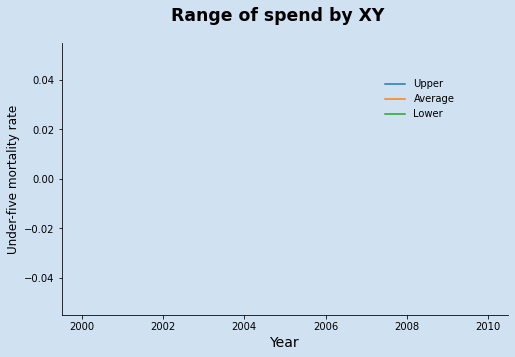

In [63]:
# https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
# This graph: https://swdevnotes.com/python/2020/display-line-chart-range/

politician = 'XY'

# df_c = u5mr_df.loc[([country]), :]
df_c = politician_grouped_by_day_new
days = df_c.ad_creation_time
lower = df_c.sum_spend_lo
average = df_c.avg_spend
upper = df_c.sum_spend_hi

title = f'Range of spend by {politician}'

fig, ax = plt.subplots(figsize = (8,5), facecolor = plt.cm.Blues(.2))
fig.suptitle(title, fontsize = 'xx-large',  fontweight = 'bold')

ax.set_facecolor(plt.cm.Blues(.2))
ax.plot(days, upper, label = 'Upper')
ax.plot(days, average, label = 'Average')
ax.plot(days, lower, label = 'Lower')
ax.legend(bbox_to_anchor = (0.9, 0.9),
          loc = 'upper right',
          frameon = False,
          fontsize = 'medium')
ax.set_ylabel('Under-five mortality rate', fontsize = 'large')
ax.set_xlabel('Year', fontsize=14)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [ ]:
no_ads = by_page["no_ads"].sum()
no_sites = len(by_page)
print(f"Dataset contains {no_sites} pages with total of {no_ads} ads.")
ads_per_page = no_ads/no_sites
total_appr = int(538 * ads_per_page)
print(f"Therefore whole dataset contains appr. {total_appr} ads")

In [ ]:
import sys
sys.path.append('../src') 
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

data = preprocess.file_to_df("..\\data\\all_politicians_aggregated.txt")

In [ ]:
data[data["ad_creative_body"].str.contains("Climate change | climate change", na=False)]

In [ ]:
import pandas as pd
congress = pd.read_csv("..\\src\\data_sets\\legislators_fb_info.csv")

In [37]:
def check_if_in(x, arr: np.ndarray):
    return x in arr

congress["already_fetched"] = congress["page_id"].apply(lambda x: "done" if check_if_in(x, data["page_id"].values) else "missing")



,first_name,last_name,full_name,type,state,district,party,facebook,page_name,identifier,page_id,in,already_fetched
0,Sherrod,Brown,Sherrod Brown,sen,OH,NaN,Democrat,SenatorSherrodBrown,NaN,0,6266829799,match,done
1,Maria,Cantwell,Maria Cantwell,sen,WA,NaN,Democrat,senatorcantwell,Senator Maria Cantwell,100044609161538,9351652533,no_match,missing
2,Benjamin,Cardin,Benjamin L. Cardin,sen,MD,NaN,Democrat,senatorbencardin,Senator Ben Cardin,100044326544838,no match,no_match,missing
3,Thomas,Carper,Thomas R. Carper,sen,DE,NaN,Democrat,tomcarper,Senator Tom Carper,100044593172202,no match,no_match,missing
4,Robert,Casey,"Robert P. Casey, Jr.",sen,PA,NaN,Democrat,SenatorBobCasey,U.S. Senator Bob Casey,100044143479624,no match,no_match,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,Claudia,Tenney,Claudia Tenney,rep,NY,22.0,Republican,NaN,NaN,0,2220944231249057,match,done
534,Julia,Letlow,Julia Letlow,rep,LA,5.0,Republican,NaN,NaN,0,101501768597429,match,done
535,Troy,Carter,Troy A. Carter,rep,LA,2.0,Democrat,NaN,NaN,0,876319055750124,match,done
536,Melanie,Stansbury,Melanie A. Stansbury,rep,NM,1.0,Democrat,NaN,NaN,0,no match,no_match,missing


In [66]:
missing = congress[congress["already_fetched"] == "missing"]
missing.to_csv("..\\src\\data_sets\\missing_pid.csv")